In [58]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [59]:
%reload_ext autoreload

In [62]:
from pathlib import Path
import matplotlib.pyplot as plt
import skimage.io as io
import numpy
import homography, rectification, my_types, utils

In [63]:
DATA = Path("data")

# Pick Correspondences

In [72]:
PICK_NEW = False
im1_name = DATA / "doll1.jpg"
im2_name = DATA / "doll2.jpg"
im3_name = DATA / "doll3.jpg"

if PICK_NEW:
    %matplotlib tk
    im1_pts = utils.pick_points(im1_name, 8)
    im2_pts = utils.pick_points(im2_name, 8)
    # im3_pts = utils.pick_points(im3_name, 8)
    utils.save_points(im1_pts, im1_name)
    utils.save_points(im2_pts, im2_name)
    # utils.save_points(im3_pts, im3_name)
else:
    %matplotlib inline
    im1_pts = utils.load_points(im1_name)
    im2_pts = utils.load_points(im2_name)
    # im3_pts = utils.load_points(im3_name)

In [75]:
im1 = my_types.to_img_arr(im1_name)
im2 = my_types.to_img_arr(im2_name)
im3 = my_types.to_img_arr(im3_name)

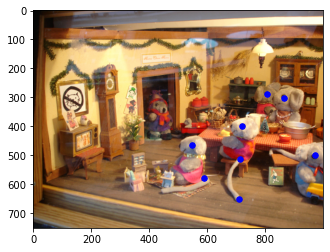

In [76]:
utils.plot_pts(im1, im1_pts)

In [90]:
import cv2

T, *_ = cv2.findHomography(im1_pts, im2_pts, cv2.RANSAC, 5.0)
print(T)

T, *_ = cv2.findHomography(im1_pts, im2_pts)
print(T)

# find homographic transformation matrix
H = homography.homo_matrix(im1_pts, im2_pts)
H

[[ 1.69109039e+00 -1.08162125e-01 -7.81765127e+02]
 [ 1.92766975e-01  1.42730359e+00 -1.57550062e+02]
 [ 7.35681482e-04 -6.74767945e-05  1.00000000e+00]]
[[ 1.48898902e+00  5.58042103e-03 -7.22616885e+02]
 [ 7.82864297e-02  1.41988665e+00 -1.13865899e+02]
 [ 4.46616118e-04  1.55935124e-04  1.00000000e+00]]


array([[ 1.16973903e+00, -4.41763292e-02, -5.34308084e+02],
       [-6.91450044e-03,  1.09612772e+00, -1.11329462e+01],
       [ 2.12107232e-04, -1.93414405e-05,  1.00000000e+00]])

In [187]:
# compare with correct functions
import skimage as sk
import cv2
T, *_ = cv2.findHomography(im1_pts, im2_pts)
warp1 = sk.transform.warp(im1, np.linalg.inv(H))
io.imshow(warp1)

-575 -14
=====src=====
(750, 1000, 3)
0 0
749 999
====target====
(837, 1100, 3)
0 0
837 1099
=====interpolate=====
[  4   4   4 ... 686 686 686]
[  42   43   44 ... 1076 1077 1078]


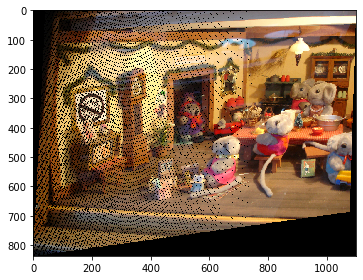

In [208]:
warp1 = homography.forward_warp(im1, H)
io.imshow(warp1)

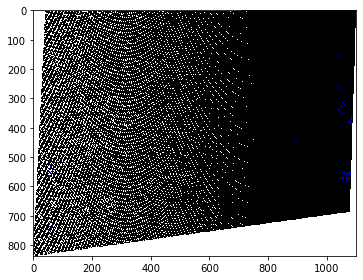

In [209]:
mask = np.ma.make_mask(warp1==0)
io.imshow(mask.astype(np.int).astype(np.float))

box = array([[   3,   41],
       [   0, 1099],
       [ 685, 1078],
       [ 836,    0]])


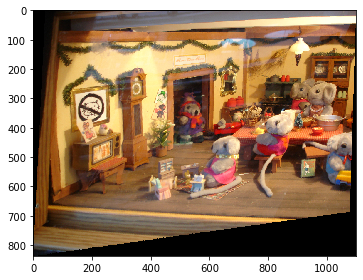

In [210]:
filled = homography.fill_holes(warp1, im1, H)
io.imshow(filled)

In [207]:
warp1 = homography.fill_holes(warp1, im1, H)
io.imshow(warp1)

-575 -14
box = array([[   3,   41],
       [   0, 1099],
       [ 685, 1078],
       [ 836,    0]])


IndexError: invalid index to scalar variable.

-575 -14
====target====
(837, 1100, 3)
1 1
835 1098
=====src=====
(750, 1000, 3)
0 0
835 759
=====interpolate=====
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


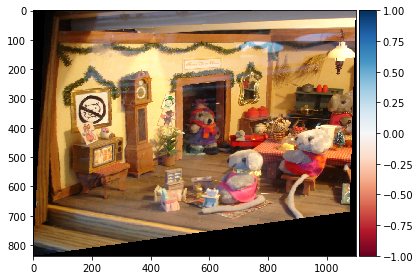

In [133]:
warp1 = homography.inverse_warp(im1, H)
io.imshow(warp1)

In [ ]:
warp1 = homography.inverse_warp(im1, H)
io.imshow(warp1)

box = array([[   3,   41],
       [   0, 1100],
       [ 686, 1078],
       [ 837,    0]])


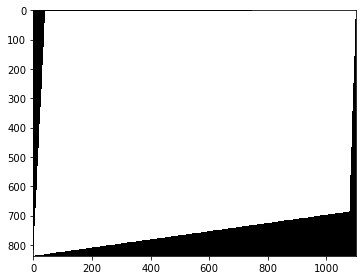

In [517]:
io.imshow(homography.inverse_mask(im1, T))